## 🎯 Problema Resuelto: Problema de Ruteo de Vehículos (VRP)
**Instancia:** 15 clientes, 3 vehículos, capacidad de 20 unidades por vehículo.
**Objetivo:** Minimizar el costo total de la flota garantizando el cumplimiento de la restricción de capacidad.

## ⚙️ Análisis de la Implementación GA

### 1. Codificación y Decodificación
| Aspecto | Implementación | Justificación Técnica |
| :--- | :--- | :--- |
| **Genotipo** | Vector continuo en rango [0, 3]. | Cada valor se mapea al índice del vehículo (0, 1, 2) al que pertenece el cliente. |
| **Decodificación** | Mapeo por normalización: `(normalized * num_vehicles).astype(int)` | Transforma el valor continuo del gen en una asignación discreta vehículo-cliente. |

### 2. Función de Fitness con Penalizaciones (Costo Aumentado)
La función de fitness es el corazón de la solución al VRP, ya que maneja la **factibilidad**.

| Componente de Penalización | Factor ($\lambda$) | Objetivo |
| :--- | :--- | :--- |
| **Exceso de Capacidad** | $\lambda_1 = 50$ | **CRÍTICO:** Castigo severo que fuerza la factibilidad (Solución 100% Factible). |
| **Infrautilización** | $\lambda_2 = 20$ | Incentiva el uso eficiente de la flota (evita rutas vacías) para minimizar el número de vehículos usados. |

### 3. Hiperparámetros Clave
| Parámetro | Valor | Rol en la Optimización |
| :--- | :--- | :--- |
| **sol_per_pop** | 60 | Población ligeramente mayor para mejor muestreo de asignaciones. |
| **keep_parents** | 8 | Alto elitismo para preservar las asignaciones de clientes factibles. |
| **crossover_type** | `uniform` | **CRÍTICO:** Intercambia genes (asignaciones de clientes) de forma más granular que el cruce de un punto, esencial para VRP. |
| **mutation_percent_genes** | 20 | Alta tasa para explorar diferentes agrupaciones de clientes rápidamente. |

## 📈 Visualizaciones
El notebook genera un tablero con 9 paneles de análisis (Gráficas [3] y [6] son exclusivas de VRP):
1.  **Curva de Convergencia:** Muestra la caída del costo total de la flota.
2.  **Evolución de Tasa de Factibilidad:** **(CRÍTICO)** Demuestra cómo las penalizaciones fuerzan la factibilidad al 100% en las primeras generaciones.
3.  **Visualización Geográfica de Rutas:** Muestra las 3 rutas saliendo y volviendo al depósito, con anotaciones de demanda de clientes.
4.  **Utilización de Capacidad:** **(CRÍTICO)** Gráfico de barras que confirma que la carga de cada vehículo está por debajo de la capacidad máxima de 20.
5.  **Distribución de Costos por Ruta:** Muestra la distribución de la distancia recorrida entre los vehículos.

--- Configuración del Problema VRP ---
Clientes: 15 | Vehículos: 3
Capacidad del Vehículo: 20
Carga Total Requerida: 52 / Capacidad Flota: 60

Iniciando optimización del VRP mediante GA...
Gen 50: Costo = 575.63 | Factible = True
Gen 100: Costo = 575.63 | Factible = True
Gen 150: Costo = 575.63 | Factible = True
Gen 200: Costo = 575.63 | Factible = True
Gen 250: Costo = 575.63 | Factible = True
Gen 300: Costo = 575.63 | Factible = True
Gen 350: Costo = 575.63 | Factible = True
Gen 400: Costo = 575.63 | Factible = True
Gen 450: Costo = 575.63 | Factible = True
Gen 500: Costo = 575.63 | Factible = True

--- Resultados Finales VRP mediante GA ---
Mejor costo total: 575.63
Solución Factible: True
Número de vehículos usados: 3
Tiempo total: 1.42 segundos
  Vehículo 1: Clientes [2, 3, 8, 12, 14] | Demanda: 17/20 | Costo: 170.49
  Vehículo 2: Clientes [1, 4, 6, 9, 10, 13] | Demanda: 17/20 | Costo: 248.28
  Vehículo 3: Clientes [5, 7, 11, 15] | Demanda: 18/20 | Costo: 156.86

Gráficos guardado

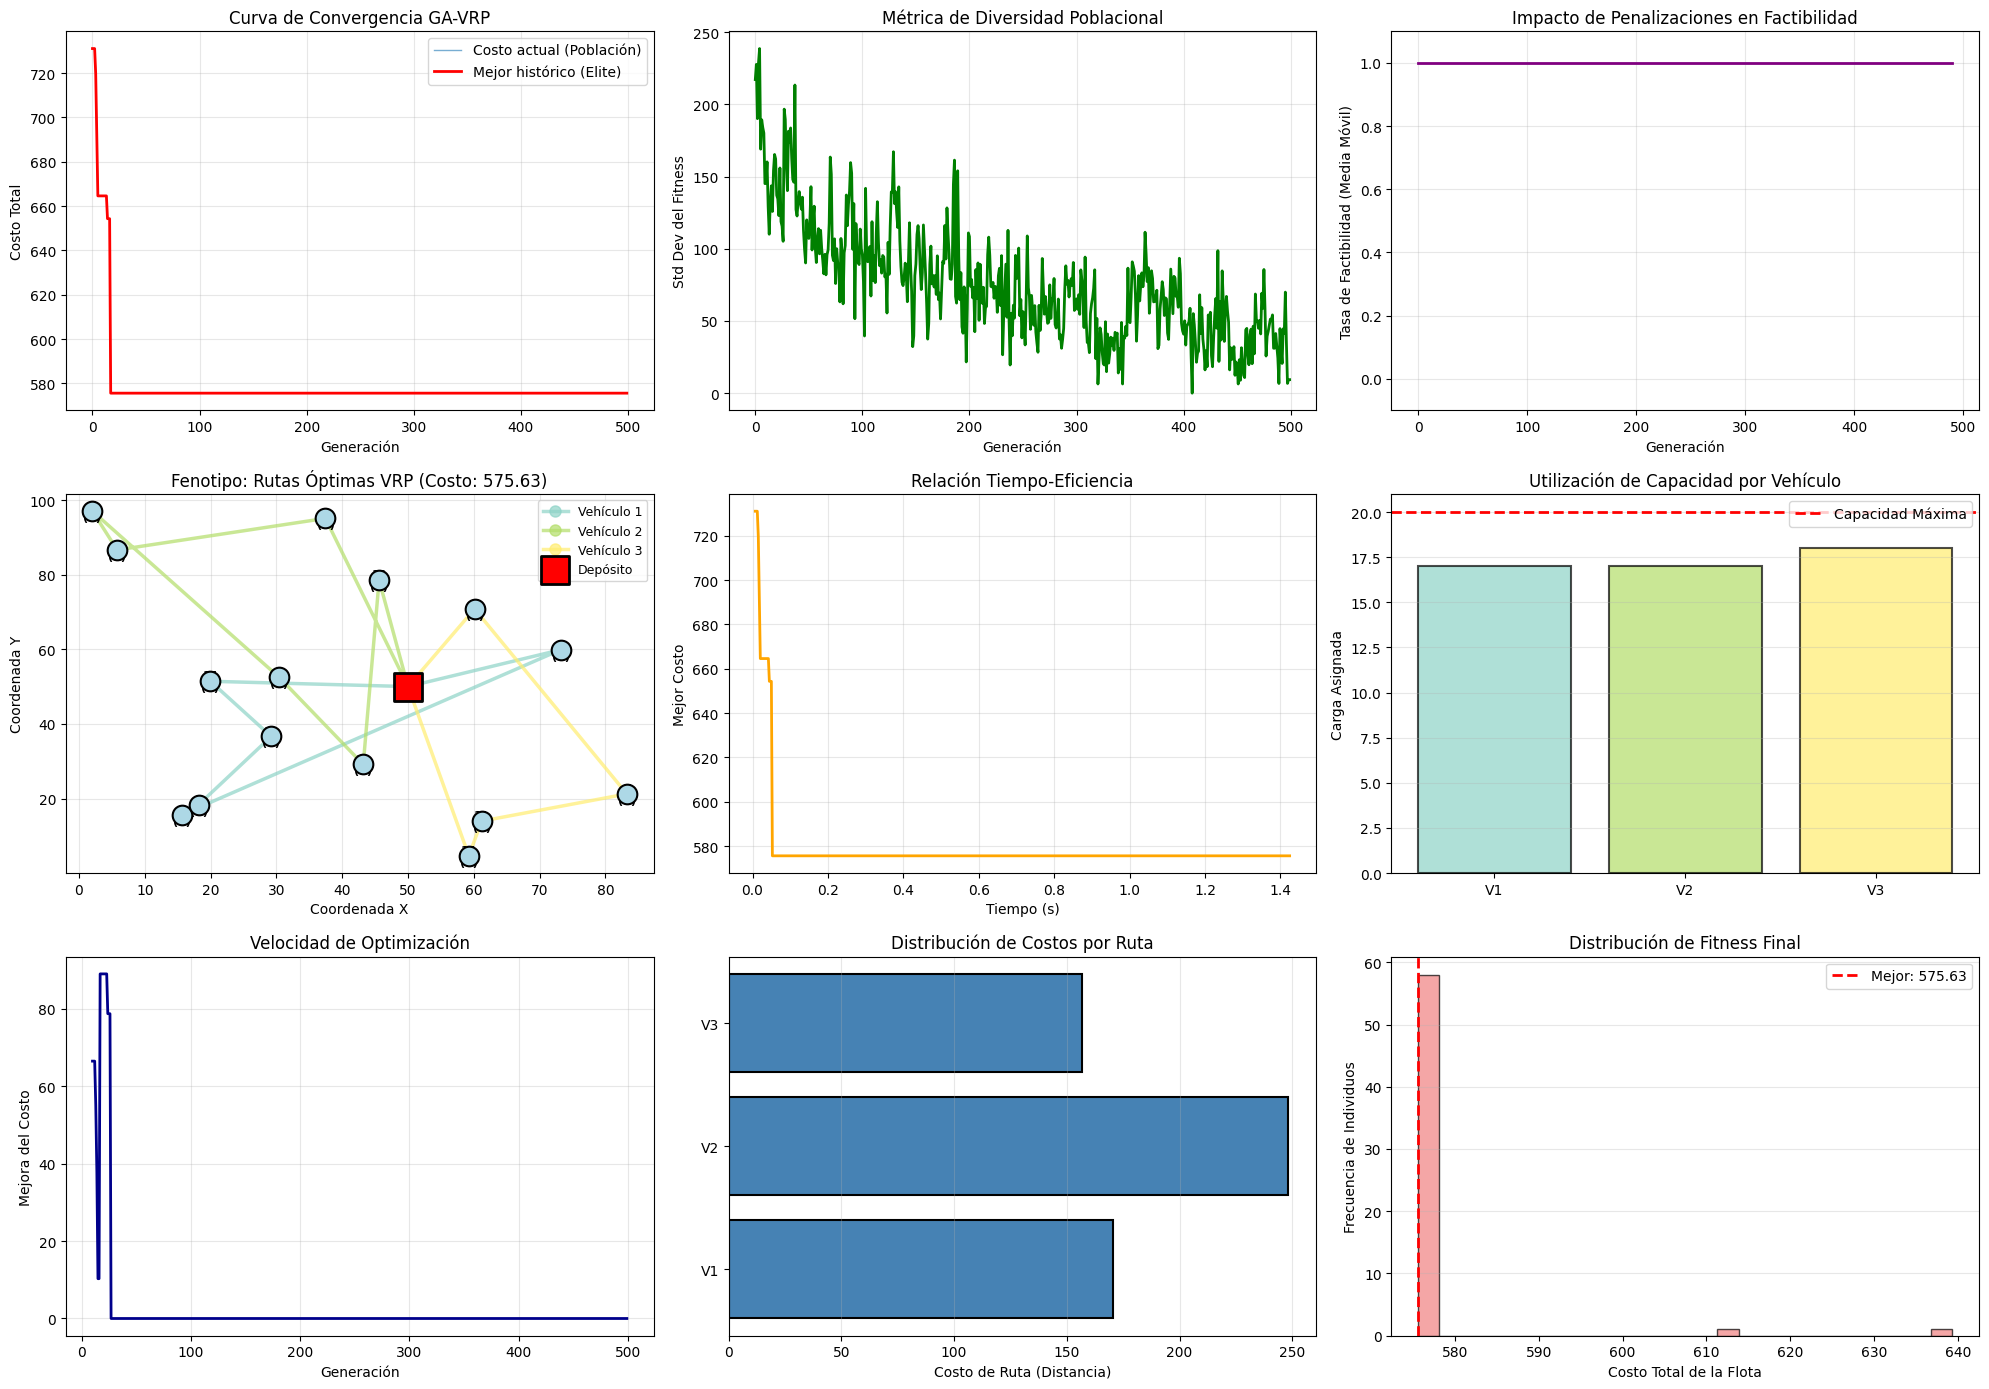


Datos guardados en 'vrp_results.npz'


In [1]:
# ==============================================================================
#Vehicle Routing Problem (VRP) resuelto con Algoritmos Genéticos usando PyGAD
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pygad
from scipy.spatial import distance_matrix
import time

# ==============================================================================
# 1. CONFIGURACIÓN DEL PROBLEMA VRP (Logística y Capacidades)
# ==============================================================================
np.random.seed(42)
num_customers = 15
num_vehicles = 3
vehicle_capacity = 20

# Ubicación del Depósito (punto de salida y retorno)
depot = np.array([[50, 50]])

# Ubicación de Clientes
customers = np.random.rand(num_customers, 2) * 100
locations = np.vstack([depot, customers])

# Demandas de carga de cada cliente (entre 1 y 7 unidades)
demands = np.random.randint(1, 8, num_customers)

# Matriz de costos (distancias euclidianas)
dist_matrix = distance_matrix(locations, locations)

print(f"--- Configuración del Problema VRP ---")
print(f"Clientes: {num_customers} | Vehículos: {num_vehicles}")
print(f"Capacidad del Vehículo: {vehicle_capacity}")
print(f"Carga Total Requerida: {np.sum(demands)} / Capacidad Flota: {num_vehicles * vehicle_capacity}")

# Variables de monitoreo
fitness_history = []
best_fitness_history = []
diversity_history = []
time_history = []
feasibility_history = []
start_time = time.time()

# ==============================================================================
# 2. DECODIFICACIÓN Y EVALUACIÓN (Lógica Evolutiva)
# ==============================================================================

def decode_solution_to_routes(solution, num_customers, num_vehicles):
    """
    Transforma el genotipo (vector continuo) en fenotipo (asignación de rutas).
    Divide a los clientes entre los vehículos disponibles.
    """
    # Normalización del cromosoma para mapeo
    normalized = (solution - solution.min()) / (solution.max() - solution.min() + 1e-10)
    
    # Asignación: Cada valor decimal determina a qué vehículo pertenece el cliente
    vehicle_assignments = (normalized * num_vehicles).astype(int)
    vehicle_assignments = np.clip(vehicle_assignments, 0, num_vehicles - 1)
    
    routes = [[] for _ in range(num_vehicles)]
    for customer_idx, vehicle_idx in enumerate(vehicle_assignments):
        routes[vehicle_idx].append(customer_idx + 1) # El 0 es el depósito
    
    return routes

def calculate_route_cost(route, dist_matrix):
    """Calcula la distancia de un ciclo: Depósito -> Clientes -> Depósito"""
    if len(route) == 0: return 0
    
    cost = dist_matrix[0, route[0]] # Salida del depósito
    for i in range(len(route) - 1):
        cost += dist_matrix[route[i], route[i + 1]]
    cost += dist_matrix[route[-1], 0] # Regreso al depósito
    return cost

def is_feasible(routes, demands, capacity):
    """Verifica el cumplimiento de la restricción de capacidad (Hard Constraint)"""
    for route in routes:
        if len(route) == 0: continue
        if sum(demands[c - 1] for c in route) > capacity:
            return False
    return True

def fitness_func(ga_instance, solution, solution_idx):
    """
    Función de Fitness con Penalizaciones.
    Maximiza la eficiencia y la factibilidad.
    """
    routes = decode_solution_to_routes(solution, num_customers, num_vehicles)
    
    # Costo base: Distancia recorrida
    total_cost = sum(calculate_route_cost(route, dist_matrix) for route in routes)
    
    # PENALIZACIONES (Función de costo aumentado)
    penalty = 0
    for route in routes:
        if len(route) > 0:
            route_demand = sum(demands[c - 1] for c in route)
            # Penalización por exceso de carga (Crítico)
            if route_demand > vehicle_capacity:
                penalty += (route_demand - vehicle_capacity) * 50 
    
    # Penalización por infrautilización (incentiva usar menos vehículos si es posible)
    empty_vehicles = sum(1 for route in routes if len(route) == 0)
    penalty += empty_vehicles * 20
    
    return -(total_cost + penalty)

def on_generation(ga_instance):
    """Callback para monitorear la evolución de la población"""
    solution, fitness, _ = ga_instance.best_solution()
    routes = decode_solution_to_routes(solution, num_customers, num_vehicles)
    
    total_cost = sum(calculate_route_cost(route, dist_matrix) for route in routes)
    fitness_history.append(total_cost)
    
    if len(best_fitness_history) == 0:
        best_fitness_history.append(total_cost)
    else:
        best_fitness_history.append(min(best_fitness_history[-1], total_cost))
    
    pop_fitness = ga_instance.last_generation_fitness
    diversity_history.append(np.std(pop_fitness))
    
    # Tracking de factibilidad (¿Cuántas soluciones cumplen la carga?)
    feasible = is_feasible(routes, demands, vehicle_capacity)
    feasibility_history.append(1 if feasible else 0)
    
    time_history.append(time.time() - start_time)
    
    if ga_instance.generations_completed % 50 == 0:
        print(f"Gen {ga_instance.generations_completed}: Costo = {total_cost:.2f} | Factible = {feasible}")

# ==============================================================================
# 3. EJECUCIÓN DEL ALGORITMO GENÉTICO
# ==============================================================================
num_generations = 500
sol_per_pop = 60

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=12,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_customers,
    init_range_low=0,
    init_range_high=num_vehicles,
    parent_selection_type="tournament",
    K_tournament=3,
    keep_parents=8,
    crossover_type="uniform",     # Cruce uniforme para mayor exploración
    mutation_type="random",       # Mutación aleatoria
    mutation_percent_genes=20,
    on_generation=on_generation,
    suppress_warnings=True
)


print("\nIniciando optimización del VRP mediante GA...")
ga_instance.run()

# ==============================================================================
# 4. ANÁLISIS DE RESULTADOS Y GRÁFICOS
# ==============================================================================
solution, fitness, _ = ga_instance.best_solution()
best_routes = decode_solution_to_routes(solution, num_customers, num_vehicles)
best_cost = sum(calculate_route_cost(route, dist_matrix) for route in best_routes)
is_feasible_solution = is_feasible(best_routes, demands, vehicle_capacity)

print(f"\n--- Resultados Finales VRP mediante GA ---")
print(f"Mejor costo total: {best_cost:.2f}")
print(f"Solución Factible: {is_feasible_solution}")
print(f"Número de vehículos usados: {sum(1 for r in best_routes if len(r) > 0)}")
print(f"Tiempo total: {time_history[-1]:.2f} segundos")

for i, route in enumerate(best_routes):
    if len(route) > 0:
        route_demand = sum(demands[c - 1] for c in route)
        route_cost = calculate_route_cost(route, dist_matrix)
        print(f"  Vehículo {i+1}: Clientes {route} | Demanda: {route_demand}/{vehicle_capacity} | Costo: {route_cost:.2f}")

# Creación de visualizaciones del rendimiento del GA-VRP
fig = plt.figure(figsize=(20, 14))

# 1. Gráfico de Convergencia
ax1 = plt.subplot(3, 3, 1)
ax1.plot(fitness_history, label='Costo actual (Población)', alpha=0.6, linewidth=1)
ax1.plot(best_fitness_history, label='Mejor histórico (Elite)', linewidth=2, color='red')
ax1.set_xlabel('Generación')
ax1.set_ylabel('Costo Total')
ax1.set_title('Curva de Convergencia GA-VRP')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Diversidad de la Población
ax2 = plt.subplot(3, 3, 2)
ax2.plot(diversity_history, color='green', linewidth=2)
ax2.set_xlabel('Generación')
ax2.set_ylabel('Std Dev del Fitness')
ax2.set_title('Métrica de Diversidad Poblacional')
ax2.grid(True, alpha=0.3)

# 3. Evolución de la Tasa de Factibilidad
ax3 = plt.subplot(3, 3, 3)
feasibility_rate = np.convolve(feasibility_history, np.ones(10)/10, mode='valid') # Media móvil
ax3.plot(range(len(feasibility_rate)), feasibility_rate, color='purple', linewidth=2)
ax3.set_xlabel('Generación')
ax3.set_ylabel('Tasa de Factibilidad (Media Móvil)')
ax3.set_title('Impacto de Penalizaciones en Factibilidad')
ax3.set_ylim([-0.1, 1.1])
ax3.grid(True, alpha=0.3)

# 4. Visualización Geográfica de las Rutas Óptimas
ax4 = plt.subplot(3, 3, 4)
colors = plt.cm.Set3(np.linspace(0, 1, num_vehicles))
for i, route in enumerate(best_routes):
    if len(route) > 0:
        route_with_depot = [0] + route + [0] # Añadir depósito al inicio y fin
        route_coords = locations[route_with_depot]
        ax4.plot(route_coords[:, 0], route_coords[:, 1], 'o-', 
                 linewidth=2.5, markersize=8, label=f'Vehículo {i+1}', 
                 color=colors[i], alpha=0.7)

ax4.scatter(depot[0, 0], depot[0, 1], c='red', s=400, marker='s', 
            zorder=10, edgecolors='black', linewidth=2, label='Depósito')
ax4.scatter(customers[:, 0], customers[:, 1], c='lightblue', s=200, 
            zorder=5, edgecolors='black', linewidth=1.5)

for i, (x, y) in enumerate(customers):
    ax4.annotate(f'{i+1}\n({demands[i]})', (x, y), fontsize=8, 
                 ha='center', va='center', weight='bold')

ax4.set_xlabel('Coordenada X')
ax4.set_ylabel('Coordenada Y')
ax4.set_title(f'Fenotipo: Rutas Óptimas VRP (Costo: {best_cost:.2f})')
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

# 5. Rendimiento Temporal del Algoritmo
ax5 = plt.subplot(3, 3, 5)
ax5.plot(time_history, best_fitness_history, linewidth=2, color='orange')
ax5.set_xlabel('Tiempo (s)')
ax5.set_ylabel('Mejor Costo')
ax5.set_title('Relación Tiempo-Eficiencia')
ax5.grid(True, alpha=0.3)

# 6. Utilización de Capacidad por Vehículo
ax6 = plt.subplot(3, 3, 6)
route_loads = []
route_labels = []
for i, route in enumerate(best_routes):
    if len(route) > 0:
        load = sum(demands[c - 1] for c in route)
        route_loads.append(load)
        route_labels.append(f'V{i+1}')

bars = ax6.bar(route_labels, route_loads, color=colors[:len(route_loads)], 
              edgecolor='black', linewidth=1.5, alpha=0.7)
ax6.axhline(vehicle_capacity, color='red', linestyle='--', linewidth=2, label='Capacidad Máxima')
ax6.set_ylabel('Carga Asignada')
ax6.set_title('Utilización de Capacidad por Vehículo')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 7. Velocidad de Optimización (Mejora por generación)
ax7 = plt.subplot(3, 3, 7)
improvements = []
window = 10
for i in range(window, len(best_fitness_history)):
    improvement = best_fitness_history[i-window] - best_fitness_history[i]
    improvements.append(improvement)
ax7.plot(range(window, len(best_fitness_history)), improvements, 
         color='darkblue', linewidth=2)
ax7.set_xlabel('Generación')
ax7.set_ylabel('Mejora del Costo')
ax7.set_title('Velocidad de Optimización')
ax7.grid(True, alpha=0.3)

# 8. Distribución de Costos Individuales por Ruta
ax8 = plt.subplot(3, 3, 8)
route_costs = [calculate_route_cost(route, dist_matrix) for route in best_routes if len(route) > 0]
route_nums = [f'V{i+1}' for i, route in enumerate(best_routes) if len(route) > 0]
ax8.barh(route_nums, route_costs, color='steelblue', edgecolor='black', linewidth=1.5)
ax8.set_xlabel('Costo de Ruta (Distancia)')
ax8.set_title('Distribución de Costos por Ruta')
ax8.grid(True, alpha=0.3, axis='x')

# 9. Distribución de Fitness en la Población Final
ax9 = plt.subplot(3, 3, 9)
final_pop_fitness = ga_instance.last_generation_fitness
ax9.hist(-final_pop_fitness, bins=25, color='lightcoral', 
         edgecolor='black', alpha=0.7)
ax9.axvline(best_cost, color='red', linestyle='--', 
            linewidth=2, label=f'Mejor: {best_cost:.2f}')
ax9.set_xlabel('Costo Total de la Flota')
ax9.set_ylabel('Frecuencia de Individuos')
ax9.set_title('Distribución de Fitness Final')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('vrp_ga_results.png', dpi=300, bbox_inches='tight')
print(f"\nGráficos guardados en 'vrp_ga_results.png'")
plt.show()

# Guardar datos para el informe (con allow_pickle para objetos complejos como las rutas)
np.savez('vrp_results.npz',
          best_cost=best_cost,
          best_routes=np.array(best_routes, dtype=object), 
          fitness_history=fitness_history,
          best_fitness_history=best_fitness_history,
          diversity_history=diversity_history,
          feasibility_history=feasibility_history,
          time_history=time_history,
          locations=locations,
          demands=demands,
          vehicle_capacity=vehicle_capacity,
          num_vehicles=num_vehicles,
          is_feasible=is_feasible_solution,
          allow_pickle=True)

print("\nDatos guardados en 'vrp_results.npz'")